In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 23.1 MB/s eta 0:00:00


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import mediapipe as mp
import csv
import os
import zipfile

zip_file_path = "final_cropped_images.zip"
extracted_folder = "extracted_images"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

folder_labels = {
    "Left": 0,
    "Center": 1,
    "Right": 2
}

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

head_landmarks = [
    mp_pose.PoseLandmark.NOSE, mp_pose.PoseLandmark.LEFT_EYE_INNER,
    mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.LEFT_EYE_OUTER,
    mp_pose.PoseLandmark.RIGHT_EYE_INNER, mp_pose.PoseLandmark.RIGHT_EYE,
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER, mp_pose.PoseLandmark.LEFT_EAR,
    mp_pose.PoseLandmark.RIGHT_EAR, mp_pose.PoseLandmark.MOUTH_LEFT, mp_pose.PoseLandmark.MOUTH_RIGHT
]

csv_file = "pose_landmarks_labeled.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Folder_Label", "Landmark", "X", "Y", "Z", "Visibility"])

    for root, dirs, files in os.walk(extracted_folder):
        for dir_name in dirs:
            if dir_name in folder_labels:
                folder_label = folder_labels[dir_name]
                folder_path = os.path.join(root, dir_name)

                for sub_root, _, image_files in os.walk(folder_path):
                    for file_name in image_files:
                        image_path = os.path.join(sub_root, file_name)

                        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            print(f"Processing: {image_path}")

                            image = cv2.imread(image_path)
                            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            image = cv2.resize(image, (640, 480))

                            results = pose.process(image_rgb)

                            if results.pose_landmarks:
                                for id, landmark in enumerate(results.pose_landmarks.landmark):
                                    if mp_pose.PoseLandmark(id) not in head_landmarks:
                                        landmark_name = mp_pose.PoseLandmark(id).name
                                        writer.writerow([
                                            file_name, folder_label, landmark_name, landmark.x, landmark.y, landmark.z, landmark.visibility
                                        ])
                            else:
                                writer.writerow([file_name, folder_label, "N/A", "N/A", "N/A", "N/A", "N/A"])
                            annotated_image = image.copy()
                            if results.pose_landmarks:
                                mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                            cv2_imshow(annotated_image)

pose.close()
print(f"Processing complete. Landmarks saved to {csv_file}.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
df = pd.read_csv('pose_landmarks_labeled.csv')

import pandas as pd

landmark_order = [
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_PINKY", "RIGHT_PINKY",
    "LEFT_INDEX", "RIGHT_INDEX", "LEFT_THUMB", "RIGHT_THUMB",
    "LEFT_HIP", "RIGHT_HIP", "LEFT_KNEE", "RIGHT_KNEE",
    "LEFT_ANKLE", "RIGHT_ANKLE", "LEFT_HEEL", "RIGHT_HEEL",
    "LEFT_FOOT_INDEX", "RIGHT_FOOT_INDEX"
]

df = pd.read_csv('pose_landmarks_labeled.csv')

df_cleaned = df.dropna(subset=[df.columns[3], df.columns[4]])

df_cleaned['Landmark'] = pd.Categorical(df_cleaned['Landmark'], categories=landmark_order, ordered=True)
df_cleaned = df_cleaned.sort_values(by=['Image', 'Landmark'])

grouped = df_cleaned.groupby(df.columns[0])

result = grouped.apply(
    lambda group: pd.Series({
        'Coordinates': ",".join(
            f"({x},{y})" for landmark, x, y in zip(group['Landmark'], group.iloc[:, 3], group.iloc[:, 4])
            if landmark in landmark_order
        ),
        'Label': group.iloc[0, 1]
    })
).reset_index()


result.columns = ['File Name', 'Coordinates', 'Label']
result.to_csv('trainingset.csv', index=False)
print("Data has been saved to 'trainingset.csv'")


Data has been saved to 'trainingset.csv'


<ipython-input-3-6e73149b16fb>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Landmark'] = pd.Categorical(df_cleaned['Landmark'], categories=landmark_order, ordered=True)
<ipython-input-3-6e73149b16fb>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(


Unique values in Folder_Label: [1 0 2]
Unique values in Merged_Label: ['1_and_2' '0']
Number of points with label 0: 62
Number of points with label 1_and_2: 59


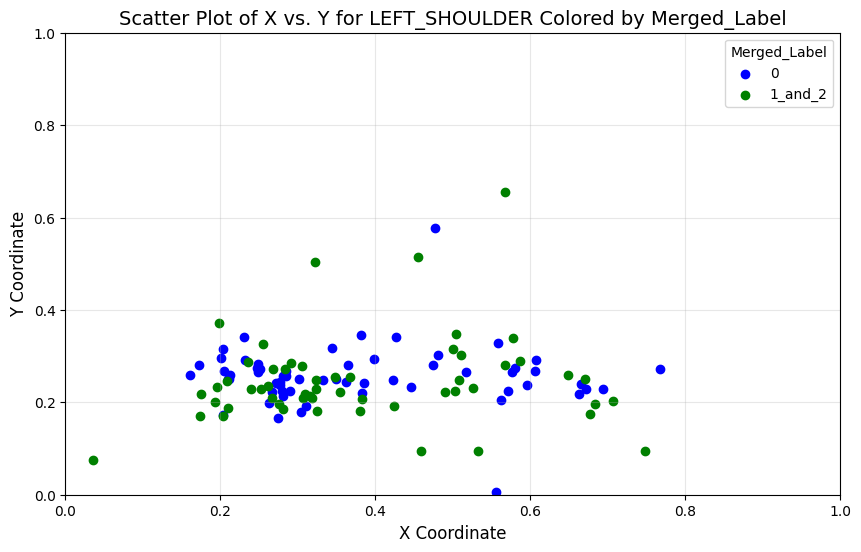

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('pose_landmarks_labeled.csv')

data = data[data['Landmark'] == 'LEFT_SHOULDER']

data['Merged_Label'] = data['Folder_Label'].replace({1: '1_and_2', 2: '1_and_2', 0: '0'}).astype(str)

print("Unique values in Folder_Label:", data['Folder_Label'].unique())
print("Unique values in Merged_Label:", data['Merged_Label'].unique())

label_0 = data[data['Merged_Label'] == '0']
label_1_and_2 = data[data['Merged_Label'] == '1_and_2']

print("Number of points with label 0:", len(label_0))
print("Number of points with label 1_and_2:", len(label_1_and_2))

plt.figure(figsize=(10, 6))

plt.scatter(label_0['X'], label_0['Y'], color='blue', label='0')
plt.scatter(label_1_and_2['X'], label_1_and_2['Y'], color='green', label='1_and_2')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.title('Scatter Plot of X vs. Y for LEFT_SHOULDER Colored by Merged_Label', fontsize=14)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.legend(title='Merged_Label', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
df = pd.read_csv('trainingset.csv')
print(df['Label'].value_counts())

Label
0    62
2    40
1    19
Name: count, dtype: int64


SMOTE data balance

In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("trainingset.csv")

# Convert 'Coordinates' column back to Python lists
data["Coordinates"] = data["Coordinates"].apply(eval)

# Convert 3D coordinate data (121, 22, 2) into 2D (121, 44) by flattening x and y
coordinate_features = np.array(data["Coordinates"].tolist()).reshape(len(data), -1)

# Create feature column names
feature_columns = [f"Coord_{i}" for i in range(coordinate_features.shape[1])]

# Combine coordinate features with labels into a new DataFrame
numeric_data = pd.DataFrame(coordinate_features, columns=feature_columns)
numeric_data["Label"] = data["Label"]

# Split features and target
X = numeric_data.drop(columns=["Label"])
y = numeric_data["Label"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Combine resampled data into the original format
resampled_coordinates = [
    ",".join(f"({x},{y})" for x, y in zip(row[::2], row[1::2]))  # Pair (x, y) back together
    for row in X_train_resampled.values  # Ensure proper iteration over resampled features
]

# Create a DataFrame with the resampled data in the original format
resampled_data = pd.DataFrame({
    "File Name": [f"Resampled_{i}" for i in range(len(resampled_coordinates))],  # Placeholder file names
    "Coordinates": resampled_coordinates,
    "Label": y_train_resampled
})

# Save the resampled data to a new CSV file
resampled_data.to_csv("trainingset_SMOTE.csv", index=False)

# Print confirmation
print("Resampled data has been saved in the original format to 'trainingset_resampled_original_format.csv'")


Resampled data has been saved in the original format to 'trainingset_resampled_original_format.csv'


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
df = pd.read_csv('trainingset_SMOTE.csv')
print(df['Label'].value_counts())

Label
1    49
0    49
2    49
Name: count, dtype: int64


NN.Linear

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('trainingset_SMOTE.csv')

data['Coordinates'] = data['Coordinates'].apply(
    lambda x: [float(coord) for point in x.split(',') for coord in point.strip('()').split(',')]
)

X = torch.tensor(data['Coordinates'].tolist(), dtype=torch.float32)

label_encoder = LabelEncoder()
y = torch.tensor(label_encoder.fit_transform(data['Label']), dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
#class PenaltyKickPredictor(nn.Module):
#   def __init__(self, input_size, output_size):
#        super(PenaltyKickPredictor, self).__init__()
#        self.fc = nn.Linear(input_size, output_size)
#
#    def forward(self, x):
#        return self.fc(x)

#input_size = X.shape[1]
#output_size = len(label_encoder.classes_)

#model = PenaltyKickPredictor(input_size, output_size)

In [ ]:
input_size = X.shape[1]
output_size = len(label_encoder.classes_)


model = nn.Sequential(
    nn.Linear(input_size, output_size))

In [ ]:
input_size

44

In [ ]:
#class PenaltyKickPredictor(nn.Module):
#    def __init__(self, input_size, output_size):
#        super(PenaltyKickPredictor, self).__init__()
#        self.fc1 = nn.Linear(input_size, 128)
#        self.relu = nn.ReLU()
#        self.fc2 = nn.Linear(128, 64)
#        self.fc3 = nn.Linear(64, output_size)

#    def forward(self, x):
#        x = self.fc1(x)
#        x = self.relu(x)
#        x = self.fc2(x)
#        x = self.relu(x)
#        x = self.fc3(x)
#        return x

#input_size = X.shape[1]  # Number of features (coordinates)
#output_size = len(label_encoder.classes_)  # Number of unique labels (classes)

#model = PenaltyKickPredictor(input_size, output_size)

In [ ]:
input_size = X.shape[1]
output_size = len(label_encoder.classes_)


model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, output_size)
)

Epoch [100/2000], Train Loss: 1.0419, Validation Loss: 1.0665, Train Accuracy: 50.98%, Validation Accuracy: 45.45%
Epoch [200/2000], Train Loss: 0.9796, Validation Loss: 1.0317, Train Accuracy: 50.98%, Validation Accuracy: 45.45%
Epoch [300/2000], Train Loss: 0.9236, Validation Loss: 1.0046, Train Accuracy: 54.90%, Validation Accuracy: 50.00%
Epoch [400/2000], Train Loss: 0.8695, Validation Loss: 0.9780, Train Accuracy: 62.75%, Validation Accuracy: 50.00%
Epoch [500/2000], Train Loss: 0.8103, Validation Loss: 0.9511, Train Accuracy: 65.69%, Validation Accuracy: 59.09%
Epoch [600/2000], Train Loss: 0.7476, Validation Loss: 0.9254, Train Accuracy: 65.69%, Validation Accuracy: 59.09%
Epoch [700/2000], Train Loss: 0.6870, Validation Loss: 0.8983, Train Accuracy: 71.57%, Validation Accuracy: 68.18%
Epoch [800/2000], Train Loss: 0.6273, Validation Loss: 0.8706, Train Accuracy: 75.49%, Validation Accuracy: 68.18%
Epoch [900/2000], Train Loss: 0.5695, Validation Loss: 0.8506, Train Accuracy: 7

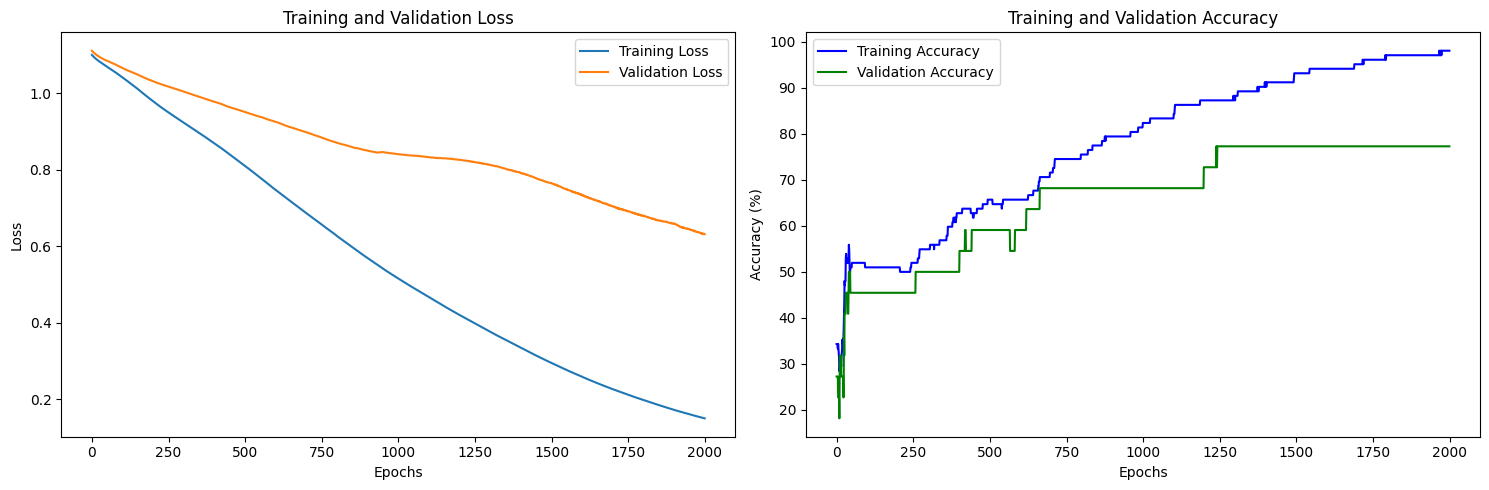

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, y_train)
    train_loss.backward()
    optimizer.step()

    _, train_predictions = torch.max(train_outputs, 1)
    train_accuracy = accuracy_score(y_train, train_predictions)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        _, val_predictions = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val, val_predictions)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy * 100)
    val_accuracies.append(val_accuracy * 100)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, "
              f"Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from torch import nn

for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight')
        print(layer.state_dict()['weight'])
        print('bias')
        print(layer.state_dict()['bias'])

weight
tensor([[ 0.1447,  0.0973,  0.0727,  ..., -0.1656, -0.0288, -0.1945],
        [ 0.0720,  0.0344,  0.1608,  ...,  0.0780,  0.1161,  0.0253],
        [-0.0038,  0.0916, -0.1106,  ...,  0.0904, -0.0421, -0.0464],
        ...,
        [ 0.1755,  0.1511,  0.1910,  ..., -0.0813, -0.2082,  0.0389],
        [ 0.1081,  0.2784,  0.3123,  ...,  0.1603,  0.1616,  0.0236],
        [-0.0098,  0.1502,  0.0888,  ...,  0.0332,  0.2798,  0.0689]])
bias
tensor([ 0.1941,  0.2934, -0.0994,  0.0039,  0.0658,  0.1777,  0.0354,  0.2258,
        -0.1422, -0.1999, -0.1790, -0.1826,  0.1375, -0.0191,  0.3224,  0.1327,
         0.0425, -0.1333, -0.2687,  0.0809,  0.1703, -0.0246, -0.1517, -0.2045,
        -0.1768,  0.1795,  0.0717,  0.0527, -0.0695,  0.0041, -0.1080, -0.1644,
         0.2401,  0.0186, -0.1482,  0.2275,  0.0166,  0.0069,  0.2068, -0.0541,
         0.2473,  0.2864,  0.0338, -0.1171, -0.0358, -0.0307,  0.3293,  0.0794,
         0.0332, -0.0429,  0.1379,  0.1186,  0.2041,  0.1653, -0.1705, -0.

Test Accuracy: 73.91%


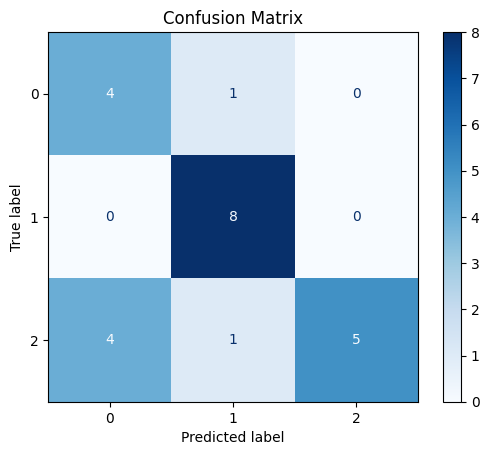

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predictions = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import mediapipe as mp
import csv

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

image_path = "testing.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (640, 480))
cv2_imshow(image)

results = pose.process(image_rgb)

if results.pose_landmarks:
    landmarks = []
    head_landmarks = [
        mp_pose.PoseLandmark.NOSE, mp_pose.PoseLandmark.LEFT_EYE_INNER,
        mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.LEFT_EYE_OUTER,
        mp_pose.PoseLandmark.RIGHT_EYE_INNER, mp_pose.PoseLandmark.RIGHT_EYE,
        mp_pose.PoseLandmark.RIGHT_EYE_OUTER, mp_pose.PoseLandmark.LEFT_EAR,
        mp_pose.PoseLandmark.RIGHT_EAR, mp_pose.PoseLandmark.MOUTH_LEFT, mp_pose.PoseLandmark.MOUTH_RIGHT,
    ]

    for id, landmark in enumerate(results.pose_landmarks.landmark):
        if id in [l.value for l in head_landmarks]:
            continue

        landmark_name = mp_pose.PoseLandmark(id).name
        landmarks.append([landmark_name, landmark.x, landmark.y, landmark.z, landmark.visibility])

    csv_file = "pose_landmarks.csv"
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Landmark", "X", "Y", "Z", "Visibility"])
        writer.writerows(landmarks)

    print(f"Pose landmarks saved to {csv_file}.")

    annotated_image = image.copy()
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(annotated_image)
else:
    print("No pose landmarks detected.")

pose.close()


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import pandas as pd

landmark_order = [
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_PINKY", "RIGHT_PINKY",
    "LEFT_INDEX", "RIGHT_INDEX", "LEFT_THUMB", "RIGHT_THUMB",
    "LEFT_HIP", "RIGHT_HIP", "LEFT_KNEE", "RIGHT_KNEE",
    "LEFT_ANKLE", "RIGHT_ANKLE", "LEFT_HEEL", "RIGHT_HEEL",
    "LEFT_FOOT_INDEX", "RIGHT_FOOT_INDEX"
]
df = pd.read_csv('pose_landmarks.csv')
df['Landmark'] = pd.Categorical(df['Landmark'], categories=landmark_order, ordered=True)
df_sorted = df.sort_values(by='Landmark')
df_sorted['Coordinates'] = df_sorted.apply(lambda row: f"({row['X']},{row['Y']})", axis=1)
coordinates_string = ",".join(df_sorted['Coordinates'])
print(coordinates_string)

In [ ]:
import torch

new_coordinates = [(0.361914724111557,0.2121863663196563),(0.4582645893096924,0.2826632857322693),(0.2870343327522278,0.1697254478931427),(0.4345737099647522,0.4304607212543487),(0.2331126481294632,0.1241885721683502),(0.4312392175197601,0.5903418064117432),(0.2007449716329574,0.1049291789531707),(0.4288528859615326,0.6306691765785217),(0.2036637961864471,0.1002429723739624),(0.4311170279979706,0.6305729150772095),(0.2165073007345199,0.1079077422618866),(0.4337729811668396,0.6158322691917419),(0.3744141459465027,0.5100868344306946),(0.4488721787929535,0.5277602672576904),(0.5119253993034363,0.6533900499343872),(0.5737005472183228,0.6127168536186218),(0.5792800784111023,0.8235166072845459),(0.7045691013336182,0.7988800406455994),(0.5854809284210205,0.8566979765892029),(0.7030704021453857,0.8487833738327026),(0.6080830097198486,0.8521542549133301),(0.750383198261261,0.8154201507568359)
]
flattened_coordinates = [coord for point in new_coordinates for coord in point]
input_tensor = torch.tensor([flattened_coordinates], dtype=torch.float32)


model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, prediction = torch.max(output, 1)
predicted_label = label_encoder.inverse_transform(prediction.numpy())
print(f"Predicted Label: {predicted_label[0]}")